In [2]:
import pandas as pd
import numpy as np
import warnings 
import matplotlib.pyplot as plt
import seaborn as sns
warnings.simplefilter('ignore')

In [1]:
def gnss_log_to_dataframes(path):
    '''Load GNSS Log'''
    print('Loading ' + path, flush = True)
    gnss_section_names = {'Raw', 'UncalAccel', 'UncalGyro', 'UncalMag', 'Fix', 'Status', 'OrientationDeg'}
    with open(path) as f_open:
        datalines = f_open.readlines()

    datas = {k: [] for k in gnss_section_names}
    gnss_map = {k: [] for k in gnss_section_names}
    for dataline in datalines:
        is_header = dataline.startswith('#')
        dataline = dataline.strip('#').strip().split(',')
        # skip over notes, version numbers, etc
        if is_header and dataline[0] in gnss_section_names:
            gnss_map[dataline[0]] = dataline[1:]
        elif not is_header:
            datas[dataline[0]].append(dataline[1:])

    results = dict()
    for k, v in datas.items():
        results[k] = pd.DataFrame(v, columns=gnss_map[k])
    # pandas doesn't properly infer types from these lists by default
    for k, df in results.items():
        for col in df.columns:
            if col == 'CodeType':
                continue
            results[k][col] = pd.to_numeric(results[k][col])

    return results

In [3]:
# apply tips1
# _derivedのmillisSinceGpsEpochが次のepoch(rawの)を示しているので元に戻す
def apply_tips1(raw_df, derived_df):
    # Create a new column in df_raw that corresponds to derivedの['millisSinceGpsEpoch']
    raw_df['millisSinceGpsEpoch'] = np.floor((raw_df['TimeNanos'] - raw_df['FullBiasNanos']) / 1000000.0).astype(int)
        
    # Change each value in df_derived['MillisSinceGpsEpoch'] to be the prior epoch.
    raw_timestamps = raw_df['millisSinceGpsEpoch'].unique()
    derived_timestamps = derived_df['millisSinceGpsEpoch'].unique()

    # The timestamps in derived are one epoch ahead. We need to map each epoch
    # in derived to the prior one (in Raw).
    indexes = np.searchsorted(raw_timestamps, derived_timestamps)
    from_t_to_fix_derived = dict(zip(derived_timestamps, raw_timestamps[indexes-1]))
    derived_df['millisSinceGpsEpoch'] = np.array(list(map(lambda v: from_t_to_fix_derived[v], derived_df['millisSinceGpsEpoch'])))
    return derived_df

In [4]:
# apply tips2
# Compute signal_type in df_raw.
# Map from constellation id to frequencies and signals.
CONSTEL_FREQ_TABLE = {
    0: {'UNKNOWN': (0, 999999999999)},
    1: {
        'GPS_L1': (1563000000, 1587000000),
        'GPS_L2': (1215000000, 1240000000),
        'GPS_L5': (1164000000, 1189000000)
    },
    3: {
        'GLO_G1': (1593000000, 1610000000),
        'GLO_G2': (1237000000, 1254000000)
    },
    4: {
        'QZS_J1': (1563000000, 1587000000),
        'QZS_J2': (1215000000, 1240000000),
        'QZS_J5': (1164000000, 1189000000)
    },
    5: {
        'BDS_B1C': (1569000000, 1583000000),
        'BDS_B1I': (1553000000, 1568990000),
        'BDS_B2A': (1164000000, 1189000000),
        'BDS_B2B': (1189000000, 1225000000)
    },
    6: {
        'GAL_E1': (1559000000, 1591000000),
        'GAL_E5A': (1164000000, 1189000000),
        'GAL_E5B': (1189000000, 1218000000),
        'GAL_E6': (1258000000, 1300000000)
    },
    7: {
        'IRN_S': (2472000000, 2512000000),
        'IRN_L5': (1164000000, 1189000000)
    },
}

def SignalTypeFromConstellationAndFequency(constel, freq_hz):
  'Returns the signal type as a string for the given constellation and frequency.'
  freqs = CONSTEL_FREQ_TABLE.get(constel, {})
  for id_freq_range in freqs.items():
    rng = id_freq_range[1]
    if rng[0] <= freq_hz <= rng[1]:
      return id_freq_range[0]
  return 'UNKNOWN'

# gnsslogとderivedのsvidを一致させる
def apply_tips2(raw_df):
    # Fix QZS Svids issue. 

    # The SVID of any QZS sat in derived may be changed. Since it may be a many to one relationship, we'll need to adjust the values in Raw.
    new_to_old = {1:(183, 193), 2:(184, 194, 196), 3:(187, 189, 197, 199), 4:(185, 195, 200)}
    # Maps original svid to new svid for only ConstellationType=4.
    old_to_new={}
    for new_svid, old_svids in new_to_old.items():
        for s in old_svids:
            old_to_new[s] = new_svid
        raw_df['Svid'] = raw_df.apply(lambda r: old_to_new.get(r.Svid, r.Svid) if r.ConstellationType == 4 else r.Svid, axis=1)
    return raw_df

# derivedにはCarrierFrequencyHzがないのでsignaltypeを追加
def apply_tips3(raw_df):

    signal_types = itertools.chain(*[c.keys() for c in CONSTEL_FREQ_TABLE.values()])
    sig_type_cat = pd.api.types.CategoricalDtype(categories=signal_types)
    raw_df['SignalType'] = raw_df.apply(lambda r: SignalTypeFromConstellationAndFequency(r.ConstellationType, r.CarrierFrequencyHz), axis=1).astype(sig_type_cat)
    return raw_df

In [5]:
# apply tips5
# derivedの重複している行を削除
def apply_tips5(derived_df):
    delta_millis = derived_df['millisSinceGpsEpoch'] - derived_df['receivedSvTimeInGpsNanos'] / 1e6
    where_good_signals = (delta_millis > 0) & (delta_millis < 300)
    return derived_df[where_good_signals]

In [6]:
from pathlib import Path
root_dir = Path('../input')
data_dir = root_dir/'google-smartphone-decimeter-challenge'
train_df = pd.read_csv(data_dir / "baseline_locations_train.csv")

In [7]:
from tqdm.notebook import tqdm
cname = '2021-04-22-US-SJC-1'
pname = 'SamsungS20Ultra'
gnss_df = gnss_log_to_dataframes(str(data_dir / "train" / cname / pname / f'{pname}_GnssLog.txt'))
raw_df = gnss_df['Raw']
derived_df = pd.read_csv(data_dir/"train"/cname/pname/f'{pname}_derived.csv')

# pseudorangeの修正
derived_df['correctedPrM'] = derived_df.apply(lambda r: r.rawPrM + r.satClkBiasM - r.isrbM - r.ionoDelayM - r.tropoDelayM,axis=1)
# raw_df = apply_tips2(raw_df)
# raw_df = apply_tips3(raw_df)
derived_df = apply_tips1(raw_df, derived_df)
derived_df = apply_tips5(derived_df)

Loading ../input/google-smartphone-decimeter-challenge/train/2021-04-22-US-SJC-1/SamsungS20Ultra/SamsungS20Ultra_GnssLog.txt


In [8]:
cname, pname

('2021-04-22-US-SJC-1', 'SamsungS20Ultra')

In [9]:
import glob
import re
target_date = int(re.sub('-', '', cname)[:8])
target_date

if os.path.exists(f"../google-sdc-corrections/osr/json/{cname}.json"):
    osr_df = pd.read_json(f"../google-sdc-corrections/osr/json/{cname}.json", lines=True)
else:
    json_list = glob.glob("../google-sdc-corrections/osr/json/*.json")
    json_list = [p for p in json_list if len(p.split('-'))==4]
    file_list = []
    for file_path in json_list:
        file_name = file_path.split('/')[-1] 
        start_date = int(file_name[:8])
        end_date = int(file_name[13:21])

        # TODO 1こ以上ある場合に対処
        if (start_date <= target_date)&(target_date<=end_date):
            print(file_path)
            osr_df = pd.read_json(file_path, lines=True)
osr_df.drop(["payload"], axis=1, inplace=True)

../google-sdc-corrections/osr/json/202104222100-202104222300.json


In [10]:
def decode_osr(df):
    # MSG_OBS
    obs = df[df["msg_type"]==74].dropna(axis=1)
    header = pd.json_normalize(obs["header"], sep="_")
    obs = pd.concat([obs.drop(["header"], axis=1).reset_index(drop=True), header], axis=1)

    # MSG_BASE_POS_ECEF
    # 基地局のECEF座標
    base_pos = df[df["msg_type"]==72].dropna(axis=1)
    # x = base_pos["x"].dropna().unique()
    # y = base_pos["y"].dropna().unique()
    # z = base_pos["z"].dropna().unique()

    # MSG_EPHEMERIS_GPS
    # GPS衛星のエフェメリスデータ
    gps = osr_df[osr_df["msg_type"]==138].dropna(axis=1)
    common = pd.json_normalize(gps["common"], sep="_")
    toc = pd.json_normalize(gps["toc"], sep="_")
    gps = pd.concat([gps.drop(["common"], axis=1).reset_index(drop=True), common], axis=1)
    gps = pd.concat([gps.drop(["toc"], axis=1).reset_index(drop=True), toc], axis=1)
    gps = gps.drop_duplicates().reset_index(drop=True)

    # MSG_EPHEMERIS_BDS
    bds = osr_df[osr_df["msg_type"]==137].dropna(axis=1)
    common = pd.json_normalize(bds["common"], sep="_")
    toc = pd.json_normalize(bds["toc"], sep="_")
    bds = pd.concat([bds.drop(["common"], axis=1).reset_index(drop=True), common], axis=1)
    bds = pd.concat([bds.drop(["toc"], axis=1).reset_index(drop=True), toc], axis=1)
    bds = bds.drop_duplicates().reset_index(drop=True)

    # MSG_EPHEMERIS_GAL
    gal = osr_df[osr_df["msg_type"]==141].dropna(axis=1)
    common = pd.json_normalize(gal["common"], sep="_")
    toc = pd.json_normalize(gal["toc"], sep="_")
    gal = pd.concat([gal.drop(["common"], axis=1).reset_index(drop=True), common], axis=1)
    gal = pd.concat([gal.drop(["toc"], axis=1).reset_index(drop=True), toc], axis=1)
    gal = gal.drop_duplicates().reset_index(drop=True)

    # MSG_EPHEMERIS_GLO
    glo = osr_df[osr_df["msg_type"]==139].dropna(axis=1)
    common = pd.json_normalize(glo["common"], sep="_")
    glo = pd.concat([glo.drop(["common"], axis=1).reset_index(drop=True), common], axis=1)
    glo["xpos"] = glo["pos"].apply(lambda x: x[0])
    glo["ypos"] = glo["pos"].apply(lambda x: x[1])
    glo["zpos"] = glo["pos"].apply(lambda x: x[2])
    glo["xvel"] = glo["vel"].apply(lambda x: x[0])
    glo["yvel"] = glo["vel"].apply(lambda x: x[1])
    glo["zvel"] = glo["vel"].apply(lambda x: x[2])
    glo["xacc"] = glo["acc"].apply(lambda x: x[0])
    glo["yacc"] = glo["acc"].apply(lambda x: x[1])
    glo["zacc"] = glo["acc"].apply(lambda x: x[2])
    glo.drop(["pos", "vel", "acc"], axis=1, inplace=True)
    glo = glo.drop_duplicates().reset_index(drop=True)
    # MSG_OSR
    osr = osr_df[osr_df["msg_type"]==1600].dropna(axis=1)

    return obs, base_pos, gps, bds, gal, glo, osr

In [11]:
derived_df['signalType'].unique()

array(['GAL_E1', 'GAL_E5A', 'BDS_B1I', 'GPS_L1', 'GLO_G1', 'GPS_L5',
       'QZS_J1'], dtype=object)

In [12]:
obs, base_pos, gps, bds, gal, glo, osr = decode_osr(osr_df)

In [13]:
const_type = pd.read_csv(data_dir / "metadata/constellation_type_mapping.csv")
const_type

,constellationType,constellationName
0,0,UNKNOWN
1,1,GPS
2,2,SBAS
3,3,GLONASS
4,4,QZSS
5,5,BEIDOU
6,6,GALILEO
7,7,IRNSS


In [14]:
derived_df["constellationType"].unique()

array([6, 5, 1, 3, 4])

In [15]:
from math import *
# import kepler

def newton_kepler(meanE, e):
    E = 2 * meanE
    eps = 1e-10
    while True:
        E -= (meanE - E + e * np.sin(E)) / (e * np.cos(E) - 1)
        if abs(meanE - E + e * np.sin(E)) < eps:
            return E

def calc_sat_position(e, t, transmission_t):
    """
    t:送信時のGPSシステムの時刻(GPS時刻)をトランジットタイム（距離／光速）で補正したもの。
    tk:時刻tとエポックタイムtoeの間の実際の合計時間差であり、週の初めまたは終わりの交差を考慮しなければならない。
    tk = t - toe
    if tk > 302,400:
        tk - 604,800
    elif tk < -302,400:
        tk + 604,800
    """
    # (1)平均角速度nの計算
    mu = 3.986005*10**14 # (m3/s2) WGS 84 value of the earth's gravitational constant forGPS user
    A = e.sqrta**2  # Semi-major axis
    n0 = sqrt((mu/(A**3))) # Computed mean motion (rad/sec)
    n = n0 + e.dn  # Mean anomaly

    # (2)平均近点離角Mの計算
    # エフェメリスの基準時刻teにおける平均近点離角M0を観測時tにおける平均近点離角Mに変換
    # tは衛星から信号が送信された時刻
    # toeは基準時刻
    toe = e.toe_tow + (e.toe_wn * 3600*24*7)
    tk = (t - toe) - transmission_t  # Time from ephemeris reference epoch

    if tk > 302400:
        tk -= 604800
    elif tk < -302400:
        tk += 604800

    M = e.m0 + n*tk # Mean anomaly

    # (3)Mean anomaly Eの計算
    # 解きたい方程式 Mk = Ek - sample.ecc*sin(Ek)
    # E = kepler.solve(M, e.ecc)
    # E, cos_true_anomaly, sin_true_anomaly = kepler.kepler(M, e.ecc)
    E = newton_kepler(M, e.ecc)

    # (4) True Anomaly vの計算
    v = atan((sqrt(1-e.ecc**2) * sin(E)) / (cos(E) - e.ecc))

    # (5)摂動補正計算
    fai = v + e.w # Argument of Latitude

    # Second Harmonic Perturbations
    u = fai + e.c_us*sin(2*fai) + e.c_uc*cos(2*fai)  # 衛星飛行方向
    r = A*(1-(e.ecc*cos(E))) + e.c_rs*sin(2*fai) + e.c_rc*cos(2*fai)  # 動径方向
    i = e.inc + e.inc_dot*tk + e.c_is*sin(2*fai) + e.c_ic*cos(2*fai)  # 軌道面に直角な方向

    # 2次元位置
    x_ = r*cos(u)
    y_ = r*sin(u)

    # 補正された昇交点赤経
    omega_dot_e = 7.2921151467*(10**-5)  # (rad/s) WGS 84 value of the earth's rotation rate
    omega = e.omega0 + (e.omegadot - omega_dot_e)*tk - (omega_dot_e*e.toe_tow)

    # ３次元位置
    x = x_*cos(omega) - y_*cos(i)*sin(omega)
    y = x_*sin(omega) + y_*cos(i)*cos(omega)
    z = y_*sin(i)
    return x,y,z

## GPS

In [16]:
# import warnings
# from tqdm.notebook import tqdm
# warnings.simplefilter('ignore')

# # GPS:1 / GLONASS:3 / GALILEO:6
# # GPS衛星のもののみを取り出す
# target_derived_df = derived_df[derived_df['constellationType'] == 1]
# target_derived_df['correctedPrM'] = target_derived_df.apply(lambda r: r.rawPrM + r.satClkBiasM - r.isrbM - r.ionoDelayM - r.tropoDelayM,axis=1)
# output_df = pd.DataFrame()

# # 衛星ID, 時刻ごとに衛星位置を求める
# gr = target_derived_df.groupby(["millisSinceGpsEpoch", "svid"])
# for (epoch, svid), df in tqdm(gr, total=len(gr)):
#     # L1とL5の2つある場合もある
#     # assert len(df) == 1
#     # TODO 良いかはわからないが複数のデータがある場合1つだけ取り出している
#     df = df.iloc[0]  

#     # 観測時刻(単位:s)
#     t = epoch / 1000  # 衛星位置を知りたい時刻(s)
    
#     # 受信->送信に補正する用
#     # 時刻が受信時のものであるためそれを補正するために擬似距離/光速で補正
#     pseudorange = df['correctedPrM']
#     c = 299_792_458  # 光速
#     transmission_t = pseudorange / c

#     # gpsデータは衛星ごとに1つのよう(assertが通れば)
#     ephemeris = gps[(gps['sid_sat']==svid)].drop_duplicates().reset_index(drop=True)
#     assert len(ephemeris)==1 
#     ephemeris = ephemeris.loc[0]
#     x,y,z = calc_sat_position(ephemeris, t, transmission_t)
    
#     df['x'] = x
#     df['y'] = y
#     df['z'] = z

#     if np.abs(df["x"] - df["xSatPosM"]) > 100:
#         df['x'] = -x
#         df['y'] = -y
#         df['z'] = -z
#     output_df = pd.concat([output_df, pd.DataFrame(df).T])

In [17]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# fig = plt.figure(figsize=(6,6))
# ax = fig.add_subplot(111)
# sns.scatterplot(x='xSatPosM',y='ySatPosM', data=output_df, alpha=0.5, color='red', ax=ax, label='baseline')
# sns.scatterplot(x='x',y='y', data=output_df, alpha=0.5, ax=ax, color='blue', label='our')
# plt.legend()

In [18]:
# sns.scatterplot(x='zSatPosM',y='z', hue='svid', data=output_df)

## GLONASS

In [19]:
# http://archive.sokugikyo.or.jp/pdf/apa76_2000_08/apa76010008.pdf
def PZ90toWGS84(row):
    convert_matrix = [[1, -1.6*10**-6, 0],
                      [1.6*10**-6, 1, 0],
                      [0, 0, 1]]
    M = np.dot(convert_matrix, [[row["xpos"]],[row["ypos"]],[row["zpos"]]])
    row["x"] = M[0][0]
    row["y"] = M[1][0]
    row["z"] = M[2][0]
    return row

In [20]:
# # GPS:1 / GLONASS:3 / GALILEO:6
# target_derived_df = derived_df[derived_df['constellationType'] == 3]
# target_derived_df['correctedPrM'] = target_derived_df.apply(lambda r: r.rawPrM + r.satClkBiasM - r.isrbM - r.ionoDelayM - r.tropoDelayM,axis=1)
# output_df = pd.DataFrame()
# gr = target_derived_df.groupby(["svid"])
# for svid, df in tqdm(gr, total=len(gr)):
#     # svidが19のものは前後のデータがないので補間ができない
#     # collectionのものではなく長期間のもので行ったほうがいい?
#     # ms -> s
#     df = df.sort_values("millisSinceGpsEpoch").reset_index(drop=True)
#     df["sSinceGpsEpoch"] = (df["millisSinceGpsEpoch"]/1000).astype(int)

#     # 対象の衛星のデータのみ取得
#     e = glo[glo['sid_sat']==svid].drop_duplicates().reset_index(drop=True) 
#     # assert len(e) < 1
#     # towからepochに変換
#     e["sSinceGpsEpoch"] = e.toe_tow + (e.toe_wn * 3600*24*7)

#     # GLONASSは30minごとの衛星位置データを持つ
#     # 線形補間でderivedに存在する時刻の衛星位置を算出したい
#     _df = pd.concat([e[["xpos", "ypos", "zpos", "sSinceGpsEpoch"]], df[["millisSinceGpsEpoch", "sSinceGpsEpoch"]]], axis=0).sort_values("sSinceGpsEpoch")
#     _df["time"] = pd.to_datetime(_df["sSinceGpsEpoch"])
#     _df = _df.set_index("time") 
#     _df = _df.interpolate(limit_direction="both",method='time').reset_index(drop=True)
#     df = df.merge(_df[["millisSinceGpsEpoch", "xpos", "ypos", "zpos"]], on="millisSinceGpsEpoch")

#     df = df.apply(PZ90toWGS84, axis=1)
#     output_df = pd.concat([output_df, df])

In [21]:
# fig = plt.figure(figsize=(6,6))
# ax = fig.add_subplot()
# sns.scatterplot(x='xSatPosM',y='ySatPosM', data=output_df, ax=ax, label='baseline')
# sns.scatterplot(x='xpos',y='ypos', data=output_df, ax=ax, label='our')
# plt.legend()

In [22]:
# plt.figure(figsize=(6,6))
# sns.scatterplot(x='zSatPosM',y='zpos', hue='svid', data=output_df)

## BDS

In [23]:
# import warnings
# from tqdm.notebook import tqdm
# warnings.simplefilter('ignore')

# # GPS:1 / GLONASS:3 / GALILEO:6
# # GPS衛星のもののみを取り出す
# target_derived_df = derived_df[derived_df['constellationType'] == 5]
# target_derived_df['correctedPrM'] = target_derived_df.apply(lambda r: r.rawPrM + r.satClkBiasM - r.isrbM - r.ionoDelayM - r.tropoDelayM,axis=1)
# output_df = pd.DataFrame()

# # 衛星ID, 時刻ごとに衛星位置を求める
# gr = target_derived_df.groupby(["millisSinceGpsEpoch", "svid"])
# for (epoch, svid), df in tqdm(gr, total=len(gr)):
#     # L1とL5の2つある場合もある
#     # assert len(df) == 1
#     # TODO 良いかはわからないが複数のデータがある場合1つだけ取り出している
#     df = df.iloc[0]  

#     # 観測時刻(単位:s)
#     t = epoch / 1000  # 衛星位置を知りたい時刻(s)
    
#     # 受信->送信に補正する用
#     # 時刻が受信時のものであるためそれを補正するために擬似距離/光速で補正
#     pseudorange = df['correctedPrM']
#     c = 299_792_458  # 光速
#     transmission_t = pseudorange / c

#     if svid in list(bds['sid_sat'].unique()):
#         # gpsデータは衛星ごとに1つのよう(assertが通れば)
#         ephemeris = bds[(bds['sid_sat']==svid)].drop_duplicates().reset_index(drop=True)
    
#         ephemeris = ephemeris.iloc[0]
#         x,y,z = calc_sat_position(ephemeris, t, transmission_t)
        
#         df['x'] = x
#         df['y'] = y
#         df['z'] = z

#         if np.abs(df["x"] - df["xSatPosM"]) > 100:
#             df['x'] = -x
#             df['y'] = -y
#             df['z'] = -z
#         if 
#     else:
#         df['x'] = df['xSatPosM']
#         df['y'] = df['ySatPosM']
#         df['z'] = df['zSatPosM']
#     output_df = pd.concat([output_df, pd.DataFrame(df).T])

In [24]:
# (output_df["xSatPosM"] - output_df["x"]).hist()

In [25]:

# # GPS:1 / GLONASS:3 / BEIDOU:5 / GALILEO:6
# def satpos_estimate(derived_df, ephemeris, ctype):

#     target_derived_df = derived_df[derived_df['constellationType'] == ctype]
#     target_derived_df['correctedPrM'] = target_derived_df.apply(lambda r: r.rawPrM + r.satClkBiasM - r.isrbM - r.ionoDelayM - r.tropoDelayM,axis=1)
#     output_df = pd.DataFrame()

#     # 衛星ID, 時刻ごとに衛星位置を求める
#     gr = target_derived_df.groupby(["millisSinceGpsEpoch", "svid", "signalType"])
#     for (epoch, svid, stype), df in tqdm(gr, total=len(gr)):
#         assert len(df) == 1
#         df = df.iloc[0]  

#         # 観測時刻(単位:s)
#         t = epoch / 1000  # 衛星位置を知りたい時刻(s)
        
#         # 受信->送信に補正する用
#         # 時刻が受信時のものであるためそれを補正するために擬似距離/光速で補正
#         pseudorange = df['correctedPrM']
#         c = 299_792_458  # 光速
#         transmission_t = pseudorange / c
        
#         if svid in ephemeris['sid_sat'].unique():
#             e = ephemeris[(ephemeris['sid_sat']==svid)].drop_duplicates().iloc[0]
#             x,y,z = calc_sat_position(e, t, transmission_t)        
            
#             df['x'] = x
#             df['y'] = y
#             df['z'] = z

#             if np.abs(df["x"] - df["xSatPosM"]) > 100:
#                 df['x'] = -x
#                 df['y'] = -y
#                 df['z'] = -z
                
#         # 対象の衛星がエフェメリスデータに含まれていない場合
#         else:
#             df['x'] = df['xSatPosM']
#             df['y'] = df['ySatPosM']
#             df['z'] = df['zSatPosM']


#         output_df = pd.concat([output_df, pd.DataFrame(df).T])
#     return output_df.reset_index(drop=True)

In [26]:

# GPS:1 / GLONASS:3 / BEIDOU:5 / GALILEO:6
def satpos_estimate(derived_df, ephemeris, ctype):
    print(f"constellationType: {ctype}")
    count = 0
    target_derived_df = derived_df[derived_df['constellationType'] == ctype]
    target_derived_df['correctedPrM'] = target_derived_df.apply(lambda r: r.rawPrM + r.satClkBiasM - r.isrbM - r.ionoDelayM - r.tropoDelayM,axis=1)
    output_df = pd.DataFrame()

    # 衛星ID, 時刻ごとに衛星位置を求める
    gr = target_derived_df.groupby(["millisSinceGpsEpoch", "svid", "signalType"])
    for (epoch, svid, stype), df in tqdm(gr, total=len(gr)):
        assert len(df) == 1
        df = df.iloc[0]  

        # 観測時刻(単位:s)
        t = epoch / 1000  # 衛星位置を知りたい時刻(s)
        
        # 受信->送信に補正する用
        # 時刻が受信時のものであるためそれを補正するために擬似距離/光速で補正
        pseudorange = df['correctedPrM']
        c = 299_792_458  # 光速
        transmission_t = pseudorange / c
        
        if svid in ephemeris['sid_sat'].unique():
            e = ephemeris[(ephemeris['sid_sat']==svid)].drop_duplicates()

            # 時間の異なるeが複数ある(確認した範囲では2hのずれ)
            # 衛星位置を知りたい時間tとteが近いものを採用する
            te = e.toe_tow + (e.toe_wn * 3600*24*7)
            idx = np.argmin(np.abs(te.values - t))
            e = e.iloc[idx]
            x,y,z = calc_sat_position(e, t, transmission_t)   
            df['x'] = x
            df['y'] = y
            df['z'] = z

            # データが反転しているものがなぜかあるのでそれを補正
            if np.abs(df["x"] - df["xSatPosM"]) > 1000:
                df['x'] = -x
                df['y'] = -y
                df['z'] = -z

                # 補正してもなお大きな差がある場合はbaselineの値を使う
                if np.abs(df["x"] - df["xSatPosM"]) > 1000:
                    df['x'] = df['xSatPosM']
                    df['y'] = df['ySatPosM']
                    df['z'] = df['zSatPosM']
                    count += 1
                
        # 対象の衛星がエフェメリスデータに含まれていない場合
        else:
            df['x'] = df['xSatPosM']
            df['y'] = df['ySatPosM']
            df['z'] = df['zSatPosM']
            count += 1


        output_df = pd.concat([output_df, pd.DataFrame(df).T])
    print(f"baselineで置換した割合:{count/len(gr)}")
    return output_df.reset_index(drop=True)

In [27]:
def satpos_estimate_glonass(derived_df, ephemeris, ctype):
    # GPS:1 / GLONASS:3 / GALILEO:6
    target_derived_df = derived_df[derived_df['constellationType'] == ctype]
    target_derived_df['correctedPrM'] = target_derived_df.apply(lambda r: r.rawPrM + r.satClkBiasM - r.isrbM - r.ionoDelayM - r.tropoDelayM,axis=1)
    output_df = pd.DataFrame()
    gr = target_derived_df.groupby(["svid", "signalType"])
    for (svid,stype), df in tqdm(gr, total=len(gr)):
        # svidが19のものは前後のデータがないので補間ができない
        # collectionのものではなく長期間のもので行ったほうがいい?
        # ms -> s
        df = df.sort_values("millisSinceGpsEpoch").reset_index(drop=True)
        df["sSinceGpsEpoch"] = (df["millisSinceGpsEpoch"]/1000).astype(int)

        # 対象の衛星のデータのみ取得
        e = glo[glo['sid_sat']==svid].drop_duplicates().reset_index(drop=True) 
        # assert len(e) < 1
        # towからepochに変換
        e["sSinceGpsEpoch"] = e.toe_tow + (e.toe_wn * 3600*24*7)

        # GLONASSは30minごとの衛星位置データを持つ
        # 線形補間でderivedに存在する時刻の衛星位置を算出したい
        _df = pd.concat([e[["xpos", "ypos", "zpos", "sSinceGpsEpoch"]], df[["millisSinceGpsEpoch", "sSinceGpsEpoch"]]], axis=0).sort_values("sSinceGpsEpoch")
        _df["time"] = pd.to_datetime(_df["sSinceGpsEpoch"])
        _df = _df.set_index("time") 
        _df = _df.interpolate(limit_direction="both",method='time').reset_index(drop=True)
        df = df.merge(_df[["millisSinceGpsEpoch", "xpos", "ypos", "zpos"]], on="millisSinceGpsEpoch")

        # df = df.apply(PZ90toWGS84, axis=1)
        output_df = pd.concat([output_df, df])
    return output_df.reset_index(drop=True)

In [39]:
df_list = []
for ctype, df in derived_df.groupby(['constellationType']):
    if ctype == 1:
        df = satpos_estimate(df, gps, ctype)
    # if ctype == 3:
    #     df = satpos_estimate_glonass(df, glo, ctype)
    # elif ctype == 5:
    #     df = satpos_estimate(df, bds, ctype)
    # elif ctype == 6:
    #     df = satpos_estimate(df, gal, ctype)
    else:
        print(ctype)
        df['x'] = df['xSatPosM'].to_numpy()
        df['y'] = df['ySatPosM'].to_numpy()
        df['z'] = df['zSatPosM'].to_numpy()
    df_list.append(df)
new_derived_df = pd.concat(df_list).reset_index(drop=True)

constellationType: 1


  0%|          | 0/19441 [00:00<?, ?it/s]

baselineで置換した割合:0.0
3
4
5
6


<AxesSubplot:>

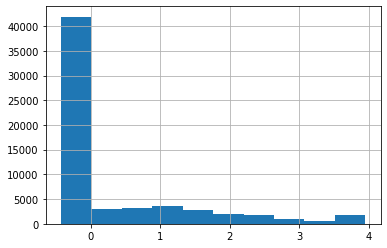

In [40]:
(new_derived_df['xSatPosM']- new_derived_df['x']).hist()

<AxesSubplot:>

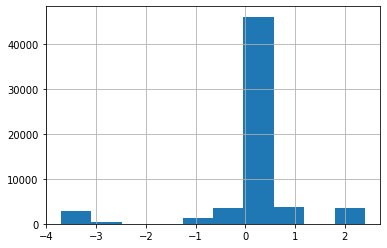

In [41]:
(new_derived_df['ySatPosM']-new_derived_df['y']).hist()

In [42]:
output_dir = '../input/derived/'
os.makedirs(output_dir, exist_ok=True)

In [43]:
cname, pname

('2021-04-22-US-SJC-1', 'SamsungS20Ultra')

In [44]:
new_derived_df = new_derived_df.drop(["xSatPosM", "ySatPosM", "zSatPosM"], axis=1).rename(columns={"x":"xSatPosM", "y":"ySatPosM", "z":"zSatPosM"})

In [45]:
derived_df.shape, new_derived_df.shape

((61290, 21), (61290, 21))

In [46]:
set(derived_df) - set(new_derived_df)

set()

In [48]:
new_derived_df.to_csv(output_dir + f'{cname}_{pname}_derived.csv', index=False)

In [ ]:
# from tqdm.notebook import tqdm
# count = 0
# for (cname,pname), df in tqdm(train_df.groupby(['collectionName', 'phoneName'])):
#     if 'SJC' in cname:   
#         print(cname)
#         gnss_df = gnss_log_to_dataframes(str(data_dir / "train" / cname / pname / f'{pname}_GnssLog.txt'))
#         raw_df = gnss_df['Raw']
#         derived_df = pd.read_csv(data_dir/"train"/cname/pname/f'{pname}_derived.csv')

#         # pseudorangeの修正
#         derived_df['correctedPrM'] = derived_df.apply(lambda r: r.rawPrM + r.satClkBiasM - r.isrbM - r.ionoDelayM - r.tropoDelayM,axis=1)
#         # raw_df = apply_tips2(raw_df)
#         # raw_df = apply_tips3(raw_df)
#         derived_df = apply_tips1(raw_df, derived_df)
#         derived_df = apply_tips5(derived_df)

#         target_date = int(re.sub('-', '', cname)[:8])

#         if os.path.exists(f"../google-sdc-corrections/osr/json/{cname}.json"):
#             osr_df = pd.read_json(f"../google-sdc-corrections/osr/json/{cname}.json", lines=True)
#         else:
#             json_list = glob.glob("../google-sdc-corrections/osr/json/*.json")
#             json_list = [p for p in json_list if len(p.split('-'))==4]
#             file_list = []
#             for file_path in json_list:
#                 file_name = file_path.split('/')[-1] 
#                 start_date = int(file_name[:8])
#                 end_date = int(file_name[13:21])

#                 # TODO 1こ以上ある場合に対処
#                 if (start_date <= target_date)&(target_date<=end_date):
#                     print(file_path)
#                     osr_df = pd.read_json(file_path, lines=True)
#         osr_df.drop(["payload"], axis=1, inplace=True)

#         obs, base_pos, gps, bds, gal, glo, osr = decode_osr(osr_df)
        
#         df_list = []
#         for ctype, df in derived_df.groupby(['constellationType']):
#             # とりあえずGPSだけ
#             if ctype == 1:
#                 df = satpos_estimate(df, gps, ctype)
#             if ctype == 5:
#                 df = satpos_estimate(df, bds, ctype)
#             elif ctype == 6:
#                 df = satpos_estimate(df, gal, ctype)
#             else:
#                 df['x'] = df['xSatPosM'].to_numpy()
#                 df['y'] = df['ySatPosM'].to_numpy()
#                 df['z'] = df['zSatPosM'].to_numpy()
#             df_list.append(df)